# 2B

In [522]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas._libs.parsers import k
from sklearn import preprocessing

In [523]:
mvp_stats_2b = pd.read_csv("datasets/player_mvp_stats.csv", ';')
nicknames_df = pd.read_csv("datasets/nicknames.csv", ';')
salaries_2b = pd.read_csv("datasets/salaries.csv")
teams_2b = pd.read_csv("datasets/teams.csv", ';')
us_inflation_2b = pd.read_csv("datasets/US CPI.csv")

C:\Users\imman\AppData\Local\Temp\ipykernel_1944\3205523321.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  mvp_stats_2b = pd.read_csv("datasets/player_mvp_stats.csv", ';')
C:\Users\imman\AppData\Local\Temp\ipykernel_1944\3205523321.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  nicknames_df = pd.read_csv("datasets/nicknames.csv", ';')
C:\Users\imman\AppData\Local\Temp\ipykernel_1944\3205523321.py:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  teams_2b = pd.read_csv("datasets/teams.csv", ';')


### 2B. Preprocess dan merge beberapa dataset menjadi satu

In [524]:
def dataframe_to_dict(nicknames_df, key_column_name='Name', value_column_name='Abbreviation'):
    keys = nicknames_df[key_column_name]
    values = nicknames_df[value_column_name]
    return dict(zip(keys, values))

In [525]:
def cleaning_teamsdf_removeUnimportantRows(teams_2b):
    teams_2b = teams_2b.copy()
    important_rows = ~teams_2b.W.str.contains("Division")
    return teams_2b[important_rows]

def cleaning_teamsdf_convertStripToNan(teams_2b):
    teams_2b = teams_2b.copy()
    teams_2b.GB = teams_2b.GB.replace("—", np.NAN)
    return teams_2b

def cleaning_teamsdf_convertToAppropriateDatatype(teams_2b):
    """
    preconditions:
        cleaning_teamsdf_removeUnimportantRows
         cleaning_teamsdf_convertStripToNan
    """
    teams_2b = teams_2b.copy()
    teams_2b.W = pd.to_numeric(teams_2b.W)
    teams_2b.L = pd.to_numeric(teams_2b.L)
    teams_2b['W/L%'] = pd.to_numeric(teams_2b['W/L%'])
    teams_2b.GB = pd.to_numeric(teams_2b.GB)
    teams_2b['PS/G'] = pd.to_numeric(teams_2b['PS/G'])
    teams_2b['PA/G'] = pd.to_numeric(teams_2b['PA/G'])
    teams_2b.SRS = pd.to_numeric(teams_2b.SRS)
    return teams_2b

def cleaning_anyDf_removeStarInTeamName(teams_2b, column_name='Team'):
    teams_2b = teams_2b.copy()
    teams_2b[column_name] = teams_2b[column_name].str.replace('*', '')
    return teams_2b


def cleaning_anyDf_convertTeamNamesToItsAbbrev(teams_2b, nicknames_df, column_name='Team'):
    """
    precondition:
        teams df:
            cleaning_anyDf_removeStarInTeamName
    """
    nicknames_df = nicknames_df.copy()
    teams_2b = teams_2b.copy()

    nicknames_df = nicknames_df.drop_duplicates(subset='Name', keep='first')
    mapping = dataframe_to_dict(nicknames_df)
    mapping |= dataframe_to_dict(nicknames_df, 'Abbreviation', 'Abbreviation')

    teams_2b[column_name] = list(map(
        lambda x: mapping[x],
        teams_2b[column_name]
    ))
    return teams_2b

In [526]:
teams_2b = cleaning_teamsdf_removeUnimportantRows(teams_2b)
teams_2b = cleaning_teamsdf_convertStripToNan(teams_2b)
teams_2b = cleaning_teamsdf_convertToAppropriateDatatype(teams_2b)
teams_2b = cleaning_anyDf_removeStarInTeamName(teams_2b)
teams_2b = cleaning_anyDf_convertTeamNamesToItsAbbrev(teams_2b, nicknames_df)
teams_2b

C:\Users\imman\AppData\Local\Temp\ipykernel_1944\1280597476.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  teams_2b[column_name] = teams_2b[column_name].str.replace('*', '')


,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,683.0,NaN,111.5,105.7,5.22,1991,BOS
1,44,38,537.0,12.0,105.4,105.6,-0.39,1991,PHI
2,39,43,476.0,17.0,103.1,103.3,-0.43,1991,NYK
3,30,52,366.0,26.0,101.4,106.4,-4.84,1991,WSB
4,26,56,317.0,30.0,102.9,107.5,-4.53,1991,NJN
...,...,...,...,...,...,...,...,...,...
1028,42,30,583.0,NaN,112.4,110.2,2.26,2021,DAL
1029,38,34,528.0,4.0,113.3,112.3,1.07,2021,MEM
1030,33,39,458.0,9.0,111.1,112.8,-1.58,2021,SAS
1031,31,41,431.0,11.0,114.6,114.9,-0.20,2021,NOP


In [527]:
from datetime import datetime


def cleaning_inflationDf_separateDateColumns(us_inflation_2b, column='Yearmon', format="%d-%m-%Y"):
    us_inflation_2b = us_inflation_2b.copy()

    dates = []
    for i in range(len(us_inflation_2b)):
        date = us_inflation_2b[column].iloc[i]
        date = datetime.strptime(date, format)
        dates.append(date)
    us_inflation_2b['Year']  = [date.year for date in dates]
    us_inflation_2b['Month'] = [date.month for date in dates]
    us_inflation_2b['Day']   = [date.day for date in dates]

    return us_inflation_2b


def cleaning_inflationDf_getYearByMedian(us_inflation_2b):
    """
    precondition: cleaning_inflationDf_separateDateColumns
    """
    us_inflation_2b = us_inflation_2b.copy()
    us_inflation_2b = cleaning_inflationDf_separateDateColumns(us_inflation_2b)
    us_inflation_2b = us_inflation_2b.groupby(by='Year')['CPI'].median()
    us_inflation_2b = us_inflation_2b.reset_index()
    return us_inflation_2b


def cleaning_anyDf_removeDuplicatedColumns(combined_df):
    combined_df = combined_df.copy()
    columns = combined_df.columns

    columns_tobe_removed = []
    for i in range(len(columns)):
        col1 = columns[i]
        for j in range(i+1, len(columns)):
            col2 = columns[j]

            if (combined_df[col1] == combined_df[col2]).all():
                columns_tobe_removed.append(col1)
    columns_tobe_kept = set(combined_df.columns) - set(columns_tobe_removed)
    columns_tobe_kept = list(columns_tobe_kept)
    return combined_df.loc[:, columns_tobe_kept]

def cleaning_anyDf_recalculateWLpercentage(teams_2b):
    teams_2b = teams_2b.copy()
    teams_2b['W/L%'] = 100*teams_2b.W / (teams_2b.W + teams_2b.L)
    return teams_2b

In [528]:
us_inflation_2b_cleaned = us_inflation_2b.copy()
us_inflation_2b_cleaned = cleaning_inflationDf_separateDateColumns(us_inflation_2b_cleaned)
us_inflation_2b_cleaned = cleaning_inflationDf_getYearByMedian(us_inflation_2b_cleaned)
combined_df = us_inflation_2b_cleaned.merge(teams_2b, left_on=["Year"], right_on=["Year"])
combined_df = cleaning_anyDf_recalculateWLpercentage(combined_df)
combined_df.head(3)

,Year,CPI,W,L,W/L%,GB,PS/G,PA/G,SRS,Team
0,1991,136.1,56,26,68.292683,NaN,111.5,105.7,5.22,BOS
1,1991,136.1,44,38,53.658537,12.0,105.4,105.6,-0.39,PHI
2,1991,136.1,39,43,47.560976,17.0,103.1,103.3,-0.43,NYK


In [529]:
mvp_stats_2b = mvp_stats_2b.drop('Tm', axis=1)  # karena sudah ada kolom Team
mvp_stats_2b = cleaning_anyDf_convertTeamNamesToItsAbbrev(mvp_stats_2b, nicknames_df)

In [530]:
display(mvp_stats_2b.head(2))
display(combined_df.head(2))
print('banyaknya null salaries: ', salaries_2b.Salaries.isna().sum())
print('banyaknya null player name salaries: ', salaries_2b.Name.isna().sum())
print('banyaknya null player name mvp stats: ', mvp_stats_2b.Player.isna().sum())
print('banyaknya null team name: ', combined_df.Team.isna().sum())
print()
print('banyaknya row salaries df : ', len(salaries_2b))
print('banyaknya row mvp statsdf : ', len(mvp_stats_2b))
print('banyaknya row combined df : ', len(combined_df))

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,27,82,21,26.4,3.1,6.6,476.0,0.1,...,0,0.0,LAL,58,24,707.0,5.0,106.3,99.6,6.73
1,Byron Scott,SG,29,82,82,32.1,6.1,12.8,477.0,0.9,...,0,0.0,LAL,58,24,707.0,5.0,106.3,99.6,6.73


,Year,CPI,W,L,W/L%,GB,PS/G,PA/G,SRS,Team
0,1991,136.1,56,26,68.292683,NaN,111.5,105.7,5.22,BOS
1,1991,136.1,44,38,53.658537,12.0,105.4,105.6,-0.39,PHI


banyaknya null salaries:  28074
banyaknya null player name salaries:  0
banyaknya null player name mvp stats:  0
banyaknya null team name:  0

banyaknya row salaries df :  37420
banyaknya row mvp statsdf :  14092
banyaknya row combined df :  906


In [531]:
salaries_2b = salaries_2b[["Name", "Year", "Salaries", "Rank"]]

combined_df = mvp_stats_2b.merge(combined_df, left_on=["Team", "Year"], right_on=["Team", "Year"])
combined_df = salaries_2b.merge(combined_df, left_on=["Name", "Year"], right_on=["Player", "Year"])
combined_df = cleaning_anyDf_removeDuplicatedColumns(combined_df)

combined_df.head(5)

,Year,GB_y,Rank,AST,PS/G_y,2PA,STL,3P,SRS_y,Pos,...,FG%,FTA,FT%,ORB,Pts Won,3PA,TRB,2P%,PTS,eFG%
0,2000,NaN,1,3.8,100.8,21.1,0.5,0.0,8.41,C,...,574.0,10.4,524.0,4.3,1207,0.0,13.6,575.0,29.7,574.0
1,2000,5.0,2,5.0,98.5,17.8,1.5,0.4,2.67,PF,...,497.0,5.0,765.0,2.8,408,1.0,11.8,504.0,22.9,507.0
2,2000,NaN,3,1.6,94.4,14.9,0.5,0.0,2.75,C,...,551.0,7.4,711.0,2.7,367,0.1,9.5,553.0,21.7,551.0
3,2000,23.0,4,3.0,96.6,13.4,0.8,0.0,-3.47,PF,...,459.0,3.4,735.0,1.6,0,0.1,5.7,462.0,14.9,459.0
4,2000,8.0,5,5.0,97.5,7.3,1.4,1.0,6.36,SF,...,451.0,2.7,717.0,1.4,0,3.2,6.3,506.0,12.5,501.0


### 2B. Drop missing values pada target feature

kami memutuskan untuk mendrop missing values pada target feature karena target feature merupakan ground truth. Oleh karena itu, kami tidak setuju apabila kita melakukan imputasi untuk missing values pada kolom ini. Sebab, apabila kita melakukan imputasi terhadap missing values untuk kolom ini, maka kolom ini tidak sepenuhnya menjadi ground truth lagi karena diisikan dengan data-data sintesis yang tidak diketahui kebenarannya.

In [532]:
print("Banyak missing values pada kolom Salaries: ", combined_df.Salaries.isna().sum())
combined_df = combined_df[combined_df.Salaries.notna()]
combined_df.isna().sum()

Banyak missing values pada kolom Salaries:  390


Year           0
GB_y        1571
Rank           0
AST            0
PS/G_y         0
2PA            0
STL            0
3P             0
SRS_y          0
Pos            0
DRB            0
FGA            0
Team           0
Player         0
GS             0
PA/G_y         0
W_y            0
Age            0
CPI            0
FG             0
Share          0
3P%         1117
TOV            0
2P             0
L_y            0
W/L%_y         0
PF             0
Salaries       0
FT             0
BLK            0
G              0
W/L%_x         0
GB_x           0
Pts Max        0
MP             0
FG%           25
FTA            0
FT%          230
ORB            0
Pts Won        0
3PA            0
TRB            0
2P%           43
PTS            0
eFG%          25
dtype: int64

### 2B. Train test split

In [533]:
x_2b, y_2b = combined_df.drop("Salaries", axis=1), combined_df[["Salaries"]]
x_2b.drop("Team", axis=1, inplace=True)
x_2b.drop("Player", axis=1, inplace=True)

display(x_2b.head(2))
display(y_2b.head(2))

,Year,GB_y,Rank,AST,PS/G_y,2PA,STL,3P,SRS_y,Pos,...,FG%,FTA,FT%,ORB,Pts Won,3PA,TRB,2P%,PTS,eFG%
0,2000,NaN,1,3.8,100.8,21.1,0.5,0.0,8.41,C,...,574.0,10.4,524.0,4.3,1207,0.0,13.6,575.0,29.7,574.0
1,2000,5.0,2,5.0,98.5,17.8,1.5,0.4,2.67,PF,...,497.0,5.0,765.0,2.8,408,1.0,11.8,504.0,22.9,507.0


,Salaries
0,17142000.0
1,16806000.0


In [534]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(x_2b.Pos)
x_2b.Pos = label_encoder.transform(x_2b.Pos)

In [535]:
selected_rows = x_2b.notna().all(axis=1)
x_2b = x_2b[selected_rows]
y_2b = y_2b[selected_rows]

In [536]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
x_2b = pd.DataFrame(scaler.fit_transform(x_2b), columns=x_2b.columns)
y_2b = pd.DataFrame(scaler2.fit_transform(y_2b), columns=y_2b.columns)

In [537]:
display(x_2b)
display(y_2b)

,Year,GB_y,Rank,AST,PS/G_y,2PA,STL,3P,SRS_y,Pos,...,FG%,FTA,FT%,ORB,Pts Won,3PA,TRB,2P%,PTS,eFG%
0,0.0,0.072727,0.001715,0.427350,0.458333,0.759657,0.517241,0.105263,0.745406,0.142857,...,0.691238,0.427350,0.774291,0.518519,0.459459,0.102041,0.73750,0.588098,0.646893,0.705146
1,0.0,0.400000,0.005146,0.256410,0.397436,0.570815,0.275862,0.000000,0.470193,0.142857,...,0.638387,0.290598,0.743927,0.296296,0.000000,0.010204,0.35625,0.539090,0.420904,0.638387
2,0.0,0.127273,0.006861,0.427350,0.426282,0.309013,0.482759,0.263158,0.910802,0.571429,...,0.627260,0.230769,0.725709,0.259259,0.000000,0.326531,0.39375,0.590432,0.353107,0.696801
3,0.0,0.018182,0.010292,0.213675,0.253205,0.287554,0.206897,0.210526,0.683998,0.142857,...,0.602225,0.205128,0.775304,0.222222,0.000000,0.255102,0.33750,0.547258,0.302260,0.663421
4,0.0,0.381818,0.012007,0.760684,0.477564,0.596567,0.655172,0.578947,0.678171,0.357143,...,0.623088,0.444444,0.743927,0.222222,0.202703,0.642857,0.40625,0.579930,0.683616,0.698192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,1.0,0.036364,0.833619,0.025641,0.689103,0.025751,0.103448,0.184211,0.605558,0.571429,...,0.543811,0.034188,0.675101,0.018519,0.000000,0.234694,0.08125,0.848308,0.093220,0.000695
5352,1.0,0.309091,0.833619,0.076923,0.907051,0.064378,0.068966,0.078947,0.580009,0.785714,...,0.428373,0.034188,0.000506,0.018519,0.000000,0.122449,0.02500,0.424737,0.062147,0.499305
5353,1.0,0.727273,0.833619,0.162393,0.653846,0.253219,0.137931,0.210526,0.225459,0.785714,...,0.623088,0.299145,0.812753,0.092593,0.000000,0.214286,0.19375,0.543757,0.307910,0.692629
5354,1.0,0.072727,0.833619,0.025641,0.971154,0.068670,0.068966,0.078947,0.785298,0.785714,...,0.559110,0.034188,0.675101,0.018519,0.000000,0.081633,0.05625,0.530922,0.073446,0.627260


,Salaries
0,0.470790
1,0.420112
2,0.414359
3,0.333402
4,0.308427
...,...
5351,0.001359
5352,0.001359
5353,0.001359
5354,0.001359


In [547]:
from pprint import pprint
from sklearn.linear_model import Lasso

x_2b.drop('Year', inplace=True, axis=1)

lasso = Lasso(alpha=0.001)
lasso.fit(x_2b, y_2b)
print(lasso.predict(x_2b.iloc[[0]]))
print(lasso.predict(x_2b.iloc[[1]]))
print(lasso.predict(x_2b.iloc[[2]]))
pprint(
    dict(zip(x_2b.columns, list(lasso.coef_)))
)

[0.31323841]
[0.25694934]
[0.26011183]
{'2P': 0.0,
 '2P%': -0.0,
 '2PA': 0.0,
 '3P': 0.0,
 '3P%': -0.0,
 '3PA': 0.0,
 'AST': 0.0,
 'Age': 0.027942863328180103,
 'BLK': 0.0,
 'CPI': 0.09986728693454572,
 'DRB': 0.012213044249114452,
 'FG': 0.05440760525460941,
 'FG%': -0.0,
 'FGA': 0.0,
 'FT': 0.0,
 'FT%': -0.0,
 'FTA': 0.038053232594922645,
 'G': -0.04450164779113421,
 'GB_x': -0.0,
 'GB_y': -0.0,
 'GS': 0.014441176220935808,
 'L_y': -0.0,
 'MP': 0.0,
 'ORB': 0.0,
 'PA/G_y': 0.0,
 'PF': -0.0,
 'PS/G_y': 0.010046168155499415,
 'PTS': 0.0,
 'Pos': -0.0,
 'Pts Max': 0.03330999318732722,
 'Pts Won': 0.0,
 'Rank': -0.4383328473733448,
 'SRS_y': 0.0,
 'STL': 0.0,
 'Share': 0.0,
 'TOV': 0.0,
 'TRB': 0.0,
 'W/L%_x': 0.0,
 'W/L%_y': 0.0,
 'W_y': 0.0042332747981728164,
 'eFG%': -0.0}


In [539]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=7)
selector.fit(x_2b, y_2b)

input_features = selector.feature_names_in_
selected = selector.get_feature_names_out(input_features=input_features)
selected

H:\01 Kuliah\01 Dokumen\52 - KASDD\proyek-akhir\venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Year', 'Rank', 'FGA', 'CPI', 'FG', '2P', 'PTS'], dtype=object)

In [548]:
salaries_2b[salaries_2b.Salaries >= 17142000]

,Name,Year,Salaries,Rank
0,Shaquille O'Neal,2000,17142000.0,1
1871,Shaquille O'Neal,2001,19285715.0,2
1872,Kevin Garnett,2001,19610000.0,1
3742,Shaquille O'Neal,2002,21428572.0,2
3743,Kevin Garnett,2002,22400000.0,1
...,...,...,...,...
36942,Joel Embiid,2019,25467250.0,22
36943,Aaron Gordon,2019,21590909.0,41
36953,Zach LaVine,2019,19500000.0,48
37003,Tyler Johnson,2019,19245370.0,50


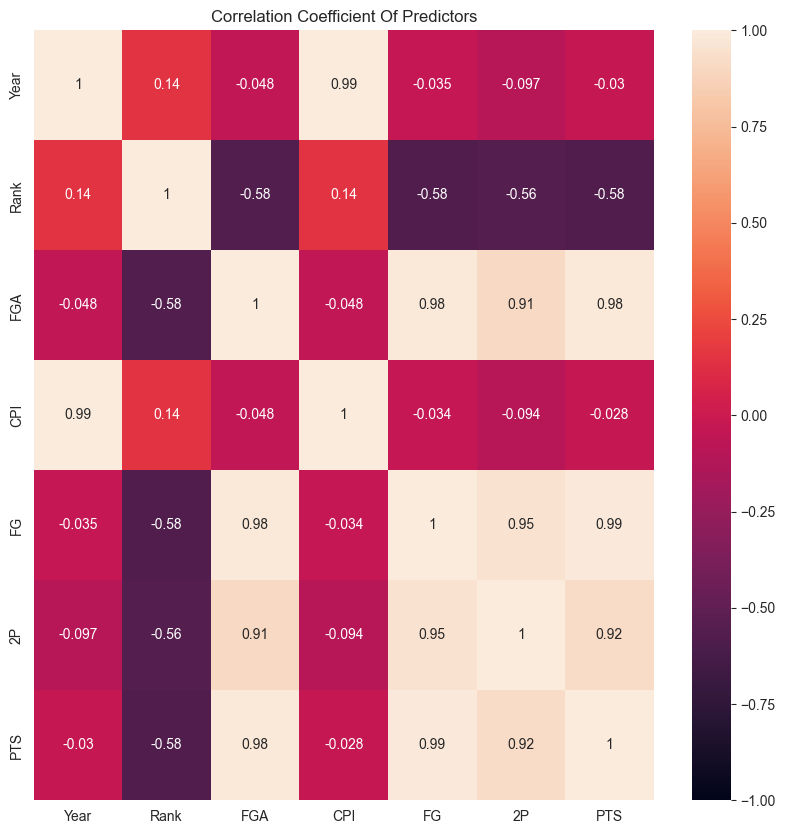

In [540]:
plt.figure(figsize=(10,10))
sns.heatmap(x_2b[selected].corr(), annot=True, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()